In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler 

from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_absolute_error

from sklearn.linear_model import LinearRegression

from sklearn.ensemble import RandomForestRegressor

In [2]:
df = pd.read_excel('C:/Work/test/Spirid2020.xlsx', index_col=[0], skiprows=[1], engine = 'openpyxl')
df.sort_index(inplace=True)
df = df.drop(['Unnamed: 6', 'Unnamed: 14', 'Unnamed: 15', 'Unnamed: 16', 'Unnamed: 17', 'Unnamed: 18', 
                'Unnamed: 19', 'Unnamed: 20', 'Unnamed: 21'], axis=1)
df.columns = ['CO', 'NO2', 'NO', 'PM10', 'PM25', 'T', 'V1', 'V2', 'Pressure', 'Humidity', 'Precipitation', 'Inversion'] 

df

,CO,NO2,NO,PM10,PM25,T,V1,V2,Pressure,Humidity,Precipitation,Inversion
Дата и время,,,,,,,,,,,,
2020-01-01 00:00:00,0.2,0.024,0.001,0.010,0.008,2.5,0.4,234.0,732.4,97.0,0.0,1.0
2020-01-01 00:20:00,0.2,0.024,0.001,0.011,0.011,2.6,0.5,0.0,732.4,97.0,0.0,1.0
2020-01-01 00:40:00,0.2,0.024,0.001,0.011,0.012,2.6,0.4,230.0,732.5,97.0,0.0,1.0
2020-01-01 01:00:00,0.1,0.024,0.001,0.013,0.012,2.7,0.4,212.0,732.6,96.5,0.0,1.0
2020-01-01 01:20:00,0.1,0.025,0.001,0.017,0.016,2.7,0.4,226.0,732.7,96.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-31 22:20:00,0.1,0.028,0.004,0.023,0.019,-0.2,1.2,0.0,749.7,95.0,0.0,0.0
2020-12-31 22:40:00,0.1,0.025,0.003,0.023,0.013,-0.4,0.6,91.0,749.9,95.3,0.0,0.0
2020-12-31 23:00:00,0.1,0.025,0.003,0.024,0.015,-0.5,0.9,0.0,749.9,95.0,0.0,0.0


In [3]:
df.index = pd.to_datetime(df.index, format='%d/%m/%Y %H:%M')

In [4]:
#ресемплирование до 1 часа
df = df.resample('1H').mean()  

## Анализ стационарности временных рядов 
Оценим, являются ли выбранные для прогноза временные ряды (концентрации CO, NO2, NO в воздухе) стационарными. Размер окна выберем равным 24 для учета концентраций в течение суток. Графики ниже показывают, что ряды являются стационарными, соответственно, можем их использовать для прогноза

In [5]:
df2 = df.copy()

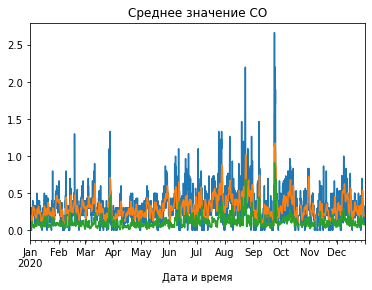

In [6]:
df2['CO_mean'] = df2['CO'].rolling(24).mean()
df2['CO_std'] = df2['CO'].rolling(24).std()
df2['CO'].plot() 
df2['CO_mean'].plot() 
df2['CO_std'].plot() 
plt.title('Среднее значение CO')
plt.show()

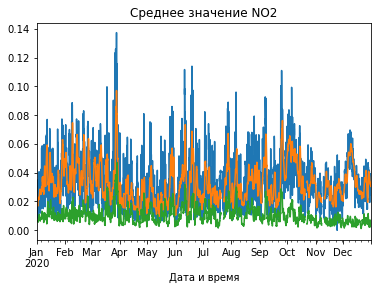

In [7]:
df2['NO2_mean'] = df2['NO2'].rolling(24).mean()
df2['NO2_std'] = df2['NO2'].rolling(24).std()
df2['NO2'].plot() 
df2['NO2_mean'].plot() 
df2['NO2_std'].plot() 
plt.title('Среднее значение NO2')
plt.show()

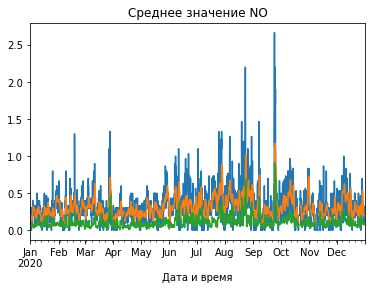

In [8]:
df2['CO_mean'] = df2['CO'].rolling(24).mean()
df2['CO_std'] = df2['CO'].rolling(24).std()
df2['CO'].plot() 
df2['CO_mean'].plot() 
df2['CO_std'].plot() 
plt.title('Среднее значение NO')
plt.show()

## Подготовка обучающей, валидационной и тестовой выборок

In [9]:
#функция для создания признаков для прогноза CO
def make_features_CO(df, max_lag, rolling_mean_size):
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['dayofweek'] = df.index.dayofweek
    df['hour'] = df.index.hour
           
    
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['CO'].shift(lag)

    df['rolling_mean'] = df['CO'].shift().rolling(rolling_mean_size).mean()

In [10]:
#функция для создания признаков для прогноза NO2
def make_features_NO2(df, max_lag, rolling_mean_size):
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['dayofweek'] = df.index.dayofweek
    df['hour'] = df.index.hour
       
   
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['NO2'].shift(lag)

    df['rolling_mean'] = df['NO2'].shift().rolling(rolling_mean_size).mean()

In [11]:
#функция для создания признаков для прогноза NO
def make_features_NO(df, max_lag, rolling_mean_size):
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['dayofweek'] = df.index.dayofweek
    df['hour'] = df.index.hour
           
    
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['NO'].shift(lag)

    df['rolling_mean'] = df['NO'].shift().rolling(rolling_mean_size).mean()

In [12]:
df_CO = df.copy()
df_NO2 = df.copy()
df_NO = df.copy()

In [13]:
#поскольку прогнозируем на сутки вперед и выполнили ресемплирование до часа, то значение lag выберем 24
make_features_CO(df_CO, 24, 24)
make_features_NO2(df_NO2, 24, 24)
make_features_NO(df_NO, 24, 24)

In [14]:
#разделение выборки на обучающую, валидационную, тестовую для CO
train_CO, test_CO = train_test_split(df_CO, shuffle=False, test_size=0.1)
train_result_CO, valid_CO = train_test_split(train_CO, shuffle=False, test_size=0.1)
train_result_CO = train_result_CO.dropna()
valid_CO = valid_CO.dropna()
test_CO = test_CO.dropna()

In [15]:
#разделение выборки на обучающую, валидационную, тестовую для NO2
train_NO2, test_NO2 = train_test_split(df_NO2, shuffle=False, test_size=0.1)
train_result_NO2, valid_NO2 = train_test_split(train_NO2, shuffle=False, test_size=0.1)
train_result_NO2 = train_result_NO2.dropna()
valid_NO2 = valid_NO2.dropna()
test_NO2 = test_NO2.dropna()

In [16]:
#разделение выборки на обучающую, валидационную, тестовую для NO
train_NO, test_NO = train_test_split(df_NO, shuffle=False, test_size=0.1)
train_result_NO, valid_NO = train_test_split(train_NO, shuffle=False, test_size=0.1)
train_result_NO = train_result_NO.dropna()
valid_NO = valid_NO.dropna()
test_NO = test_NO.dropna()

In [17]:
#выделение целевого признака для CO
X_train_CO = train_result_CO.drop(['CO', 'NO2', 'NO','PM10', 'PM25', 'V2', 'Pressure'], axis=1)
y_train_CO = train_result_CO['CO']
X_test_CO = test_CO.drop(['CO', 'NO2', 'NO', 'PM10','PM25', 'V2', 'Pressure'], axis=1) 
y_test_CO = test_CO['CO']
X_valid_CO = valid_CO.drop(['CO', 'NO2', 'NO', 'PM10','PM25', 'V2', 'Pressure'], axis=1) 
y_valid_CO = valid_CO['CO']

In [18]:
#выделение целевого признака для NO2
X_train_NO2 = train_result_NO2.drop(['CO', 'NO2', 'NO', 'PM10', 'PM25', 'V2', 'Pressure'], axis=1)
y_train_NO2 = train_result_NO2['NO2']
X_test_NO2 = test_NO2.drop(['CO', 'NO2', 'NO', 'PM10','PM25', 'V2', 'Pressure'], axis=1) 
y_test_NO2 = test_NO2['NO2']
X_valid_NO2 = valid_NO2.drop(['CO', 'NO2', 'NO', 'PM10','PM25', 'V2','Pressure'], axis=1) 
y_valid_NO2 = valid_NO2['NO2']

In [19]:
#выделение целевого признака для NO
X_train_NO = train_result_NO.drop(['CO', 'NO2', 'NO', 'PM10','PM25', 'V2',  'Pressure'], axis=1)
y_train_NO = train_result_NO['NO']
X_test_NO = test_NO.drop(['CO', 'NO2', 'NO', 'PM10','PM25', 'V2',  'Pressure'], axis=1) 
y_test_NO = test_NO['NO']
X_valid_NO = valid_NO.drop(['CO', 'NO2', 'NO','PM10','PM25', 'V2', 'Pressure'], axis=1) 
y_valid_NO = valid_NO['NO']

In [20]:
#масштабирование признаков перед обучением
scaler = StandardScaler()
scaler.fit(X_train_CO) 
X_train_CO = scaler.transform(X_train_CO)
X_test_CO = scaler.transform(X_test_CO) 
X_valid_CO = scaler.transform(X_valid_CO)

X_train_NO2 = scaler.transform(X_train_NO2)
X_test_NO2 = scaler.transform(X_test_NO2) 
X_valid_NO2 = scaler.transform(X_valid_NO2)

X_train_NO = scaler.transform(X_train_NO)
X_test_NO = scaler.transform(X_test_NO) 
X_valid_NO = scaler.transform(X_valid_NO)

pd.options.mode.chained_assignment = None

## Обучение модели и анализ точности

In [21]:
#подбор гиперпараметров для прогноза CO на основе алгоритма RandomForestRegressor
best_model = None
best_result = 100
best_est = 0
best_depth = 0
for est in range(1, 60, 10):
    for depth in range (1, 25):
        model = RandomForestRegressor(random_state=12345, n_estimators=est, max_depth=depth) 
        model.fit(X_train_CO, y_train_CO) 
        predictions_valid_CO = model.predict(X_valid_CO) 
        result = mean_absolute_error(y_valid_CO, predictions_valid_CO) 
        if result < best_result:
            best_model = model
            best_result = result
            best_est = est
            best_depth = depth

print("MAE наилучшей модели на валидационной выборке:", best_result, "Количество деревьев:", best_est, 
      "Максимальная глубина:", depth)

MAE наилучшей модели на валидационной выборке: 0.0387149380833633 Количество деревьев: 21 Максимальная глубина: 24


In [22]:
#обучение RandomForestRegressor с установленными гиперпараметрами

model_RF_CO = RandomForestRegressor(random_state=12345, n_estimators=21, max_depth=24) 
model_RF_CO.fit(X_train_CO, y_train_CO) 
predictions_test_RF_CO = model_RF_CO.predict(X_test_CO) 

print("Значение MAE тестовой выборки: ", mean_absolute_error(y_test_CO, predictions_test_RF_CO))

Значение MAE тестовой выборки:  0.04531754904814345


In [23]:
#подбор гиперпараметров для прогноза NO2 на основе алгоритма RandomForestRegressor

best_model = None
best_result = 100
best_est = 0
best_depth = 0
for est in range(1, 60, 10):
    for depth in range (1, 25):
        model = RandomForestRegressor(random_state=12345, n_estimators=est, max_depth=depth) 
        model.fit(X_train_NO2, y_train_NO2) 
        predictions_valid_NO2 = model.predict(X_valid_NO2) 
        result = mean_absolute_error(y_valid_NO2, predictions_valid_NO2)
        if result < best_result:
            best_model = model
            best_result = result
            best_est = est
            best_depth = depth

print("MAE наилучшей модели на валидационной выборке:", best_result, "Количество деревьев:", best_est, 
      "Максимальная глубина:", depth)

MAE наилучшей модели на валидационной выборке: 0.002346580539059592 Количество деревьев: 21 Максимальная глубина: 24


In [24]:
model_RF_NO2 = RandomForestRegressor(random_state=12345, n_estimators=41, max_depth=24) 
model_RF_NO2.fit(X_train_NO2, y_train_NO2) 
predictions_test_RF_NO2 = model_RF_NO2.predict(X_test_NO2) 

print("Значение MAE тестовой выборки: ", mean_absolute_error(y_test_NO2, predictions_test_RF_NO2))

Значение MAE тестовой выборки:  0.0025673546481636165


In [25]:
#подбор гиперпараметров для прогноза NO на основе алгоритма RandomForestRegressor

best_model = None
best_result = 100
best_est = 0
best_depth = 0
for est in range(1, 60, 10):
    for depth in range (1, 25):
        model = RandomForestRegressor(random_state=12345, n_estimators=est, max_depth=depth) 
        model.fit(X_train_NO, y_train_NO) 
        predictions_valid_NO = model.predict(X_valid_NO) 
        result = mean_absolute_error(y_valid_NO, predictions_valid_NO)
        if result < best_result:
            best_model = model
            best_result = result
            best_est = est
            best_depth = depth

print("MAE наилучшей модели на валидационной выборке:", best_result, "Количество деревьев:", best_est, 
      "Максимальная глубина:", depth)

MAE наилучшей модели на валидационной выборке: 0.005908703286800824 Количество деревьев: 21 Максимальная глубина: 24


In [26]:
model_RF_NO = RandomForestRegressor(random_state=12345, n_estimators=21, max_depth=24) 
model_RF_NO.fit(X_train_NO, y_train_NO) 
predictions_test_RF_NO = model_RF_NO.predict(X_test_NO) 

print("Значение MAE тестовой выборки: ", mean_absolute_error(y_test_NO, predictions_test_RF_NO))

Значение MAE тестовой выборки:  0.004244767920635733


## Оформление результатов предсказаний в итоговый dataframe

In [27]:
CO_pred = pd.DataFrame(predictions_test_RF_CO)
CO_y = pd.DataFrame(y_test_CO)
CO_y['Datetime'] = CO_y.index
CO_y = CO_y.reset_index(drop = True)
CO = pd.concat([CO_pred, CO_y], axis =1 )
CO.columns = ['CO_pr', 'CO_fact', 'Datetime']
CO_result = CO.drop(['CO_fact'], axis = 1)

In [28]:
NO2_pred = pd.DataFrame(predictions_test_RF_NO2)
NO2_y = pd.DataFrame(y_test_NO2)
NO2_y['Datetime'] = NO2_y.index
NO2_y = NO2_y.reset_index(drop = True)
NO2 = pd.concat([NO2_pred, NO2_y], axis =1 )
NO2.columns = ['NO2_pr', 'NO2_fact', 'Datetime']
NO2_result = NO2.drop(['NO2_fact'], axis = 1)

In [29]:
NO_pred = pd.DataFrame(predictions_test_RF_NO)
NO_y = pd.DataFrame(y_test_NO)
NO_y['Datetime'] = NO_y.index
NO_y = NO_y.reset_index(drop = True)
NO = pd.concat([NO_pred, NO_y], axis =1 )
NO.columns = ['NO_pr', 'NO_fact', 'Datetime']
NO_result = NO.drop(['NO_fact'], axis = 1)